<a href="https://colab.research.google.com/github/HenrySomeCode/AE_basic_denoise_anomalies_detection/blob/main/AE_basic_denoise_anomalies_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref: 

*   https://www.tensorflow.org/tutorials/generative/autoencoder



Basic

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf 

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_test.shape

(10000, 28, 28)

In [7]:
latent_dim = 64
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(28*28,activation='sigmoid'),
            layers.Reshape((28,28))
        ])
    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded
    
autoencoder = Autoencoder(latent_dim) 

In [8]:
autoencoder.compile(optimizer='adam', loss = losses.MeanSquaredError())

In [9]:
autoencoder.fit(
    x_train, x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - loss

In [10]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

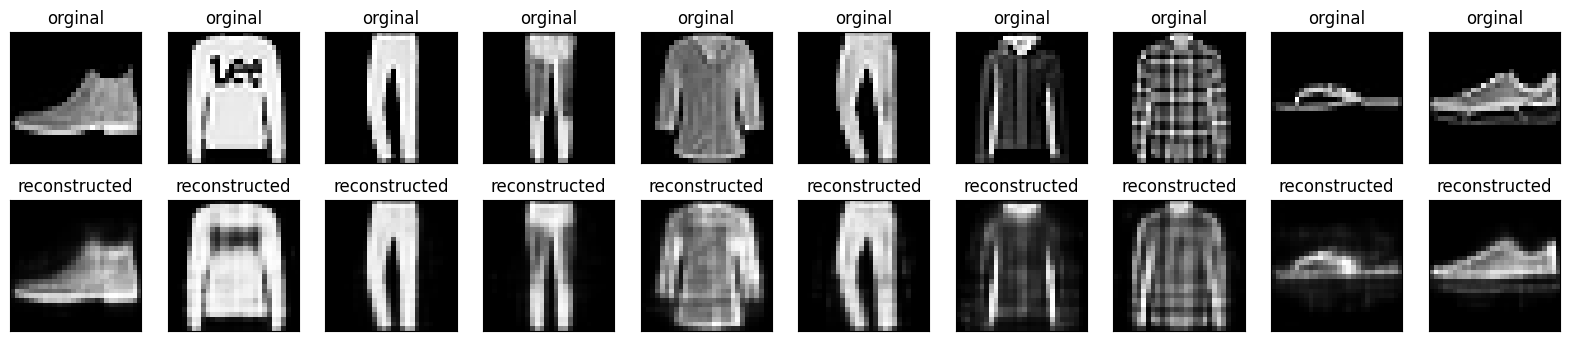

In [11]:
n=10
plt.figure(figsize=(20,4)) # size in inch
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test[i])
    plt.title("orginal")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Image Denoising

In [12]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis] # ???
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [14]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor*tf.random.normal(x_train.shape)
x_test_noisy = x_test + noise_factor*tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value (x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value (x_test_noisy, clip_value_min=0., clip_value_max=1.)

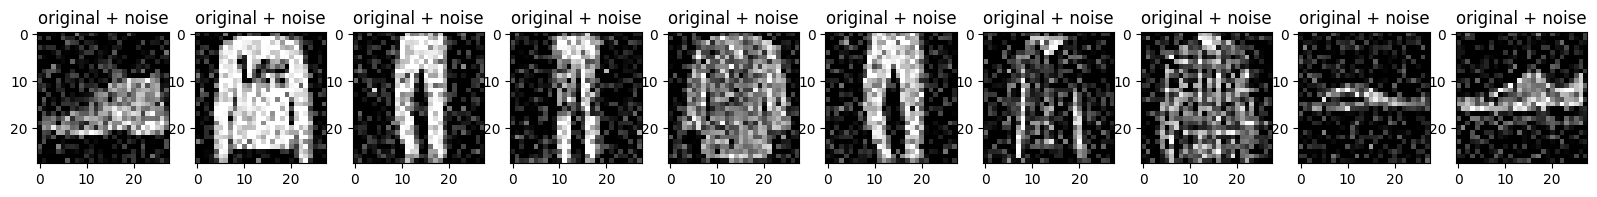

In [15]:
n=10
plt.figure(figsize=(20,2))
for i in range(n):
    ax = plt.subplot(1,n, i+1)
    plt.title("original + noise")
    # tf.squeeze removes dimensions of size 1 from the shape of a tensor, 
    # e.g Create a tensor with shape (3, 1, 2):
    # x = tf.constant([[[1, 2]],
    #                  [[3, 4]],
    #                  [[5, 6]]])
    # y = tf.squeeze(x)
    # print(y.shape) # output (3,2)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [16]:
class AutoencoderForDenoising (Model):
    def __init__(self):
        super(AutoencoderForDenoising, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(16,(3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8,(3,3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8,kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16,kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1,kernel_size=(3,3), activation='sigmoid', padding='same')
        ])

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder_for_denoising = AutoencoderForDenoising()

In [17]:
autoencoder_for_denoising.compile(optimizer='adam', loss = losses.MeanSquaredError())

In [18]:
autoencoder_for_denoising.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 93s 49ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 2/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 3/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 4/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 5/10
1875/1875 [==============================] - 117s 63ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 6/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 7/10
1875/1875 [==============================] - 95s 50ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10
1875/1875 [==============================] - 86s 4

In [19]:
encoded_imgs = autoencoder_for_denoising.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder_for_denoising.decoder(encoded_imgs).numpy()

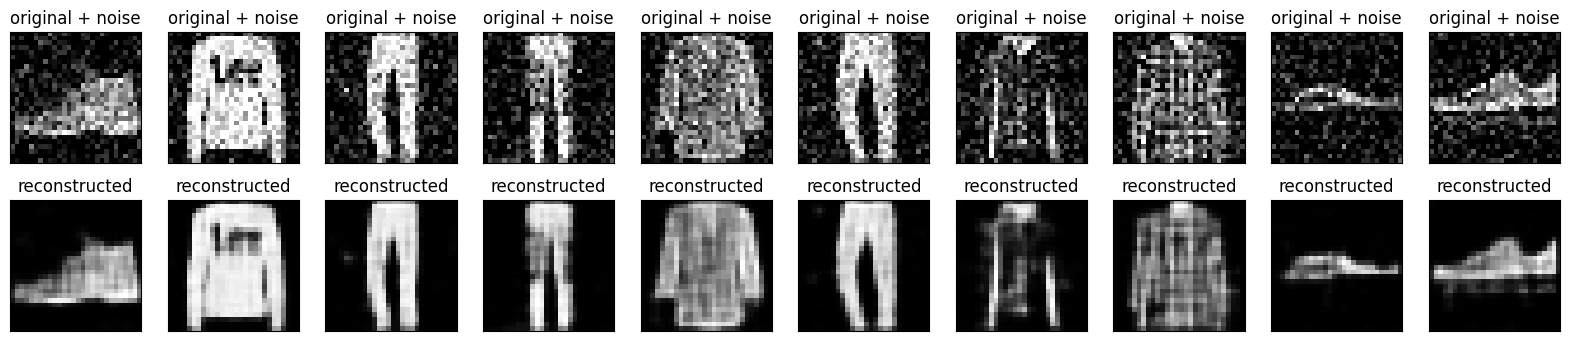

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

Anomalies Detection

In [21]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)


In [47]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [48]:
raw_data = dataframe.values

In [ ]:
raw_data

In [50]:
#last elements contain labels 
labels = raw_data[:,-1] 
labels.shape

(4998,)

In [51]:
np.where(labels == 0.)

(array([ 292,  293,  294, ..., 4995, 4996, 4997]),)

In [52]:
# ":" before comma (',') represents rows chosen, 
# "0:-1" after comma represents columns chosen
data = raw_data[:,0:-1]
data.shape

(4998, 140)

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [54]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [55]:
np.where( train_labels == 0. )

(array([   3,    7,   11, ..., 3990, 3993, 3994]),)

Normalize the data to [0,1]

In [56]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val)/(max_val - min_val)
test_data = (test_data - min_val)/(max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Since I'm going to train the autoencoder only the normal rhythms, I need to separate the normal rhythms from abnormal rhythms.

In [57]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [58]:
train_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [80]:
#take only elements that has positions in train_labels equal to True
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

In [81]:
# "~" is used to invert true and false value 
print(train_labels)
print(~train_labels)

[ True  True  True ...  True  True  True]
[False False False ... False False False]


In [82]:
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

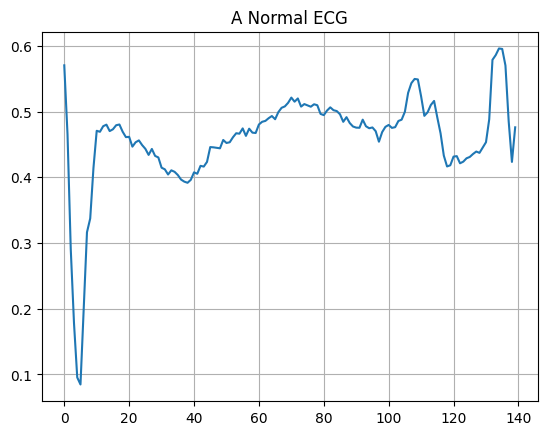

In [83]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

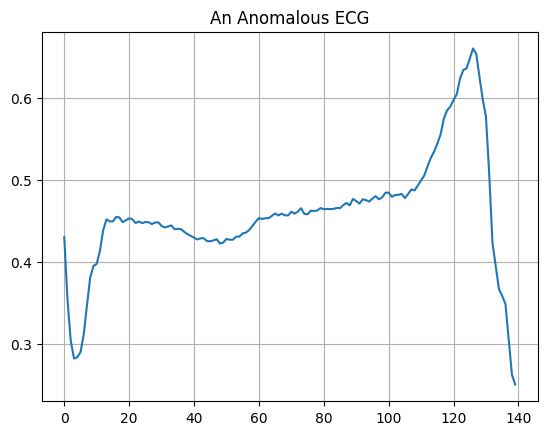

In [84]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [85]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
              layers.Dense(32, activation='relu'),
              layers.Dense(16,activation='relu'),
              layers.Dense(8,activation='relu')     
        ])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16,activation='relu'),
          layers.Dense(32,activation='relu'),
          layers.Dense(140,activation='sigmoid')
        ])

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded



In [86]:
anomaly_detector =  AnomalyDetector()

In [91]:
anomaly_detector.compile(optimizer='adam', loss='mae')

In [92]:
history = anomaly_detector.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 82ms/step - loss: 0.0582 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0562 - val_loss: 0.0515
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0536 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0500 - val_loss: 0.0477
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0459 - val_loss: 0.0466
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0421 - val_loss: 0.0445
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0384 - val_loss: 0.0422
Epoch 8/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0354 - val_loss: 0.0413
Epoch 9/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0328 - val_loss: 0.0402
Epoch 10/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0308 - val_loss: 0.0393
Epoch 11/20
5/5 [============

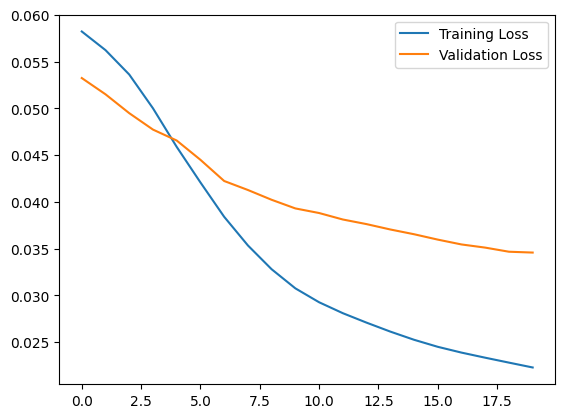

In [93]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Testing model on normal and anormalous data

In [96]:
encoded_data = anomaly_detector.encoder(normal_test_data).numpy()
decoded_data = anomaly_detector.decoder(encoded_data).numpy()

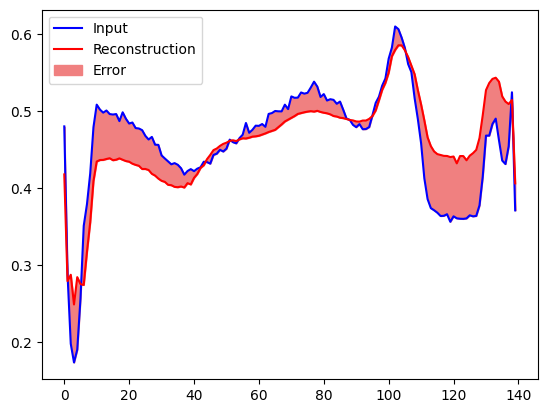

In [97]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Another way of writing code to generate datas

In [ ]:
predictions= anomaly_detector.predict(normal_test_data)
predictions[0].shape

18/18 [==============================] - 0s 2ms/step


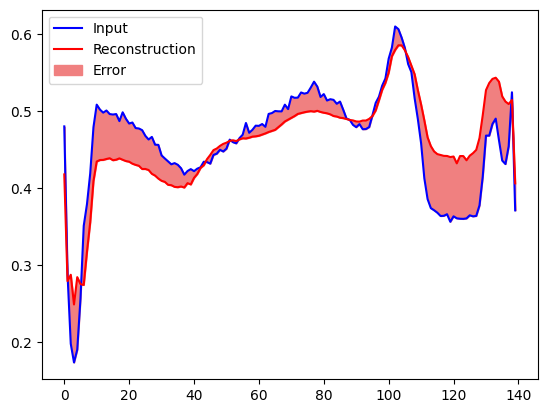

In [114]:
plt.plot(normal_test_data[0], 'b')
plt.plot(predictions[0], 'r')
plt.fill_between(np.arange(140), predictions[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_data = anomaly_detector.encoder(anomalous_test_data).numpy()
decoded_data = anomaly_detector.decoder(encoded_data).numpy()

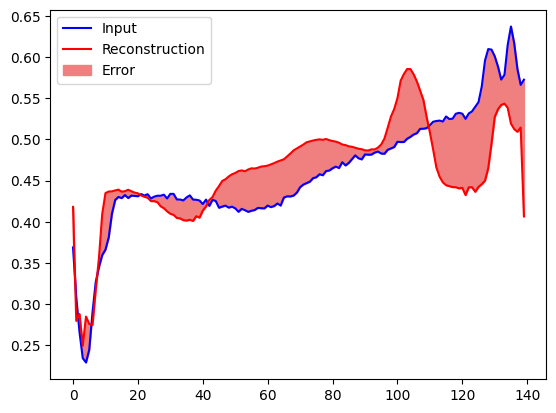

In [98]:
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [115]:
reconstructions = anomaly_detector.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 [==============================] - 0s 2ms/step


In [116]:
train_loss.shape

TensorShape([2359])

In [117]:
train_loss[None,:].shape

TensorShape([1, 2359])

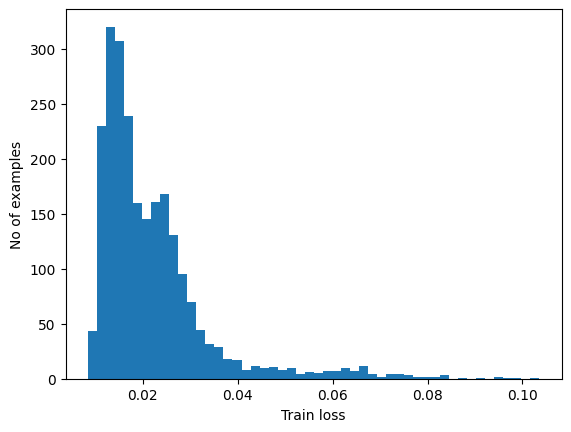

In [118]:
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

By varing the threshold, I can adjust the precision and recal of the ae model on a dataset

In [120]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.034264978


14/14 [==============================] - 0s 2ms/step


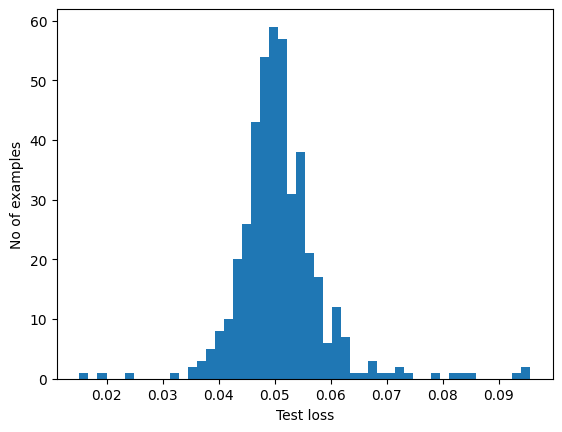

In [122]:
reconstructions = anomaly_detector.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [123]:
def predict (model, data, threshold):
    reconstructions = model(data)
    loss = tf.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [124]:
preds = predict(anomaly_detector, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
